In [194]:
import os, sys
from matplotlib import pyplot as plt
import dataclasses
from typing import Optional

sys.path.append(os.path.join(os.getcwd(), "..", "..", "simulator"))
from structs import Dataset, read_request_results, RequestResult

@dataclasses.dataclass
class Backend:
    name: str
    label: str
    color: str
    num_gpus: int
    marker: str = "o"

EXP_RESULT_ROOT="/tmp/exp-results"
SYSNAME="DistLLM"

def load_result(exp_result_dir: str, backend: Backend, per_gpu_num_prompt: int, per_gpu_request_rate: float) -> list[RequestResult]:
    possible_paths = [
        f"{EXP_RESULT_ROOT}/{exp_result_dir}/{backend.name}-{per_gpu_num_prompt*backend.num_gpus}-{per_gpu_request_rate*backend.num_gpus}.exp",
        f"{EXP_RESULT_ROOT}/{exp_result_dir}/{backend.name}-{per_gpu_num_prompt*backend.num_gpus}-{round(per_gpu_request_rate*backend.num_gpus, 4)}.exp"
    ]
    if int(per_gpu_request_rate*backend.num_gpus) == per_gpu_request_rate*backend.num_gpus:
        possible_paths.append(f"{EXP_RESULT_ROOT}/{exp_result_dir}/{backend.name}-{per_gpu_num_prompt*backend.num_gpus}-{int(per_gpu_request_rate*backend.num_gpus)}.exp")
    for path in possible_paths:
        if os.path.exists(path):
            return read_request_results(path)
    raise FileNotFoundError(f"Cannot find result file for {backend.name=}, {per_gpu_num_prompt=}, {per_gpu_request_rate=} (filename candidates: {possible_paths})")
        

def get_attainment(results: list[RequestResult], ttft_slo: Optional[float], tpot_slo: Optional[float]):
    if ttft_slo is None: ttft_slo = 1e10
    if tpot_slo is None: tpot_slo = 1e10
    counter = 0
    for result in results:
        if result.ftl <= ttft_slo and result.tpot <= tpot_slo:
            counter += 1
    return (counter / len(results))*100


In [195]:
def find_intersection(
    xs: list[float],
    ys: list[float],
    target_y: float
) -> (float, float):
    """
    Find the intersection point of the given curve (indicated by xs and ys), and
    return the X axis and Y axis of the point.
    """
    for index in range(len(xs)-1):
        x0 = xs[index]
        x1 = xs[index+1]
        y0 = ys[index]
        y1 = ys[index+1]
        if (y0 < target_y) != (y1 < target_y):
            # Intersection point found!
            inter_x = (target_y-y0) * (x1-x0) / (y1-y0) + x0
            return (inter_x, target_y)
    print(f"WARNING: Intersection point not found! xs: {xs}, ys: {ys}, target_y: {target_y}")
    return (1e-9, target_y)
    
def draw_attainment_rate_plot(
    ax: plt.Axes,
    exp_result_dir: str,
    per_gpu_num_prompt_req_rates: list[(int, float)],
    backends: list[Backend],
    ttft_slo: float,
    tpot_slo: float,
    atta_target: Optional[float] = None,
    show_ylabel: bool = False
):
    ax.set_xlabel("Per-GPU Rate (req/s)")
    if show_ylabel:
        ax.set_ylabel("SLO Attainment (%)")

    first_inter_x = -1
    for backend in backends:
        xs = [rate for _, rate in per_gpu_num_prompt_req_rates]
        ys_both = []
        ys_ttft = []
        ys_tpot = []
        for per_gpu_num_prompt, per_gpu_request_rate in per_gpu_num_prompt_req_rates:
            results = load_result(exp_result_dir, backend, per_gpu_num_prompt, per_gpu_request_rate)
            ys_both.append(get_attainment(results, ttft_slo, tpot_slo))
            ys_ttft.append(get_attainment(results, ttft_slo, None))
            ys_tpot.append(get_attainment(results, None, tpot_slo))
        ax.plot(xs, ys_both, label=backend.label, color=backend.color, marker=backend.marker)
        ax.plot(xs, ys_ttft, label=backend.label+"-TTFT", linestyle=":", color=backend.color, marker=backend.marker)
        ax.plot(xs, ys_tpot, label=backend.label+"-TPOT", linestyle="--", color=backend.color, marker=backend.marker)
        if atta_target:
            inter_x, inter_y = find_intersection(xs, ys_both, atta_target)
            ax.vlines(x = inter_x, ymin = 0, ymax = inter_y, linestyles="--", colors=backend.color)
            ax.axhline(y = atta_target, color="grey", linestyle="--")
            if first_inter_x == -1:
                first_inter_x = inter_x
                # Treat the first backend as DistServe
            else:
                print(f"Improvement ({backends[0].label} compared to {backend.label}): {first_inter_x/inter_x}")

    ax.set_ylim(0, 110)

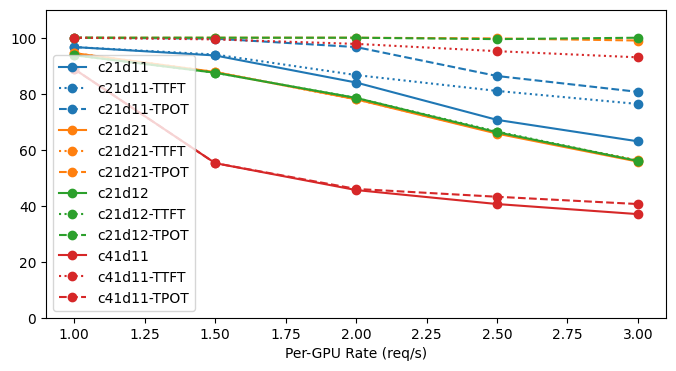

In [197]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(8, 4))
draw_attainment_rate_plot(
    ax,
    "opt-13b-sharegpt",
    [(100, 1), (100, 1.5), (100, 2), (100, 2.5), (100, 3)],
    [
        Backend("distserve-sim-c21d11", "c21d11", "C0", 3),
        Backend("distserve-sim-c21d21", "c21d21", "C1", 4),
        Backend("distserve-sim-c21d12", "c21d12", "C2", 4),
        Backend("distserve-sim-c41d11", "c41d11", "C3", 5),
    ],
    0.2,
    0.1,
)
ax.legend()
plt.show()

FileNotFoundError: Cannot find result file for backend.name='distserve', per_gpu_num_prompt=100, per_gpu_request_rate=0.25

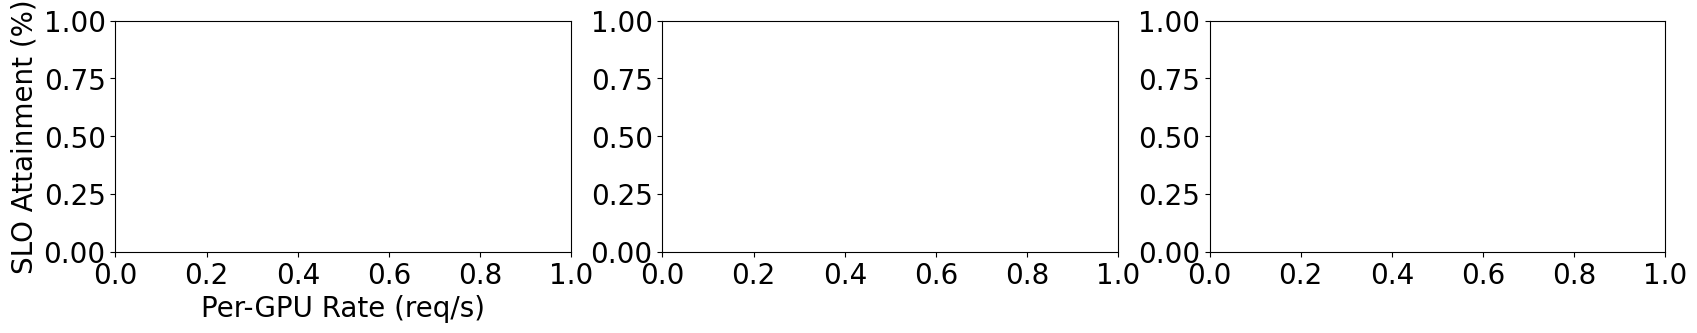

In [103]:
def plot_fig8_upper():
    plt.rcParams.update({'font.size': 20})
    fig, axs = plt.subplots(1, 3, figsize=(20, 3))
    draw_attainment_rate_plot(
        axs[0],
        "opt-13b-sharegpt",
        [(100, 0.25), (100, 0.5), (100, 1), (100, 1.5), (100, 2), (100, 2.5), (100, 3)],
        [
            Backend("distserve", SYSNAME, "C0", 3),
            Backend("vllm", "vLLM", "C1", 1)
        ],
        0.25,
        0.1,
        90,
        show_ylabel=True
    )
    fig.legend(frameon=False, bbox_to_anchor = (0.88, 1.1, 0, 0), ncol=6,
        bbox_transform = plt.gcf().transFigure, columnspacing=1)
    draw_attainment_rate_plot(
        axs[1],
        "opt-66b-sharegpt",
        [(25, 0.0625), (25, 0.125), (25, 0.25), (25, 0.375), (25, 0.5), (25, 0.625), (25, 0.75)],
        [
            Backend("distserve", SYSNAME, "C0", 8),
            Backend("vllm", "vLLM", "C1", 4)
        ],
        0.4,
        0.1,
        90
    )
    draw_attainment_rate_plot(
        axs[2],
        "opt-175b-sharegpt",
        [(25, 0.03125), (25, 0.0625), (25, 0.09375), (25, 0.125), (25, 0.15625), (25, 0.1875), (25, 0.21875), (25, 0.25), (25, 0.28125), (25, 0.3125)],
        [
            Backend("distserve", SYSNAME, "C0", 21),
            Backend("vllm", "vLLM", "C1", 8)
        ],
        4.0,
        0.2,
        90
    )
    plt.show()

plot_fig8_upper()

In [104]:
def draw_slo_scale_plot(
    ax: plt.Axes,
    exp_result_dir: str,
    per_gpu_num_prompts: int,
    per_gpu_request_rate: float,
    backends: list[Backend],
    ttft_slo: float,
    tpot_slo: float,
    scales: list[float],
    atta_target: Optional[float] = None,
    show_ylabel: bool = False
):
    ax.set_xlabel("SLO Scale")
    if show_ylabel:
        ax.set_ylabel("SLO Attainment (%)")
    scales.sort(key=lambda x: -x)
    ax.invert_xaxis()
    ax.set_ylim(0, 110)
    
    first_inter_x = -1
    for backend in backends:
        results = load_result(exp_result_dir, backend, per_gpu_num_prompts, per_gpu_request_rate)
        ys_both = []
        ys_ttft = []
        ys_tpot = []
        xs = []
        for scale in scales:
            xs.append(scale)
            ys_both.append(get_attainment(results, ttft_slo*scale, tpot_slo*scale))
            ys_ttft.append(get_attainment(results, ttft_slo*scale, None))
            ys_tpot.append(get_attainment(results, None, tpot_slo*scale))
        ax.plot(xs, ys_both, label=backend.label, color=backend.color, marker=backend.marker)
        ax.plot(xs, ys_ttft, label=backend.label+"-TTFT", linestyle=":", color=backend.color, marker=backend.marker)
        ax.plot(xs, ys_tpot, label=backend.label+"-TPOT", linestyle="--", color=backend.color, marker=backend.marker)
        if atta_target:
            inter_x, inter_y = find_intersection(xs, ys_both, atta_target)
            ax.vlines(x = inter_x, ymin = 0, ymax = inter_y, linestyles="--", colors=backend.color)
            ax.axhline(y = atta_target, color="grey", linestyle="--")
            if first_inter_x == -1:
                first_inter_x = inter_x
                # Treat the first backend as DistServe
            else:
                print(f"Improvement ({backends[0].label} compared to {backend.label}): {inter_x/first_inter_x}")

Improvement (DistLLM compared to DistLLM): 1.0
Improvement (DistLLM compared to DistLLM): 1.0
Improvement (DistLLM compared to DistLLM): 1.0


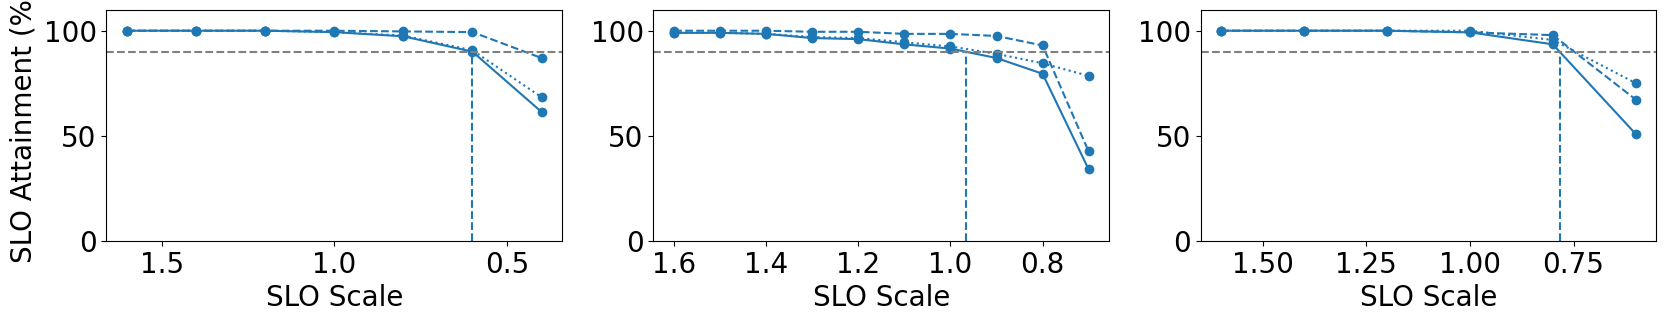

In [193]:
def plot_fig8_lower():
    plt.rcParams.update({'font.size': 20})
    fig, axs = plt.subplots(1, 3, figsize=(20, 3))
    draw_slo_scale_plot(
        axs[0],
        "opt-13b-sharegpt",
        100, 1,
        [
            Backend("fastserve-ctp2pp1-dtp1pp1", SYSNAME, "C0", 3),
            # Backend("vllm", "vLLM", "C1", 1)
        ],
        0.25,
        0.1,
        [1.6, 1.4, 1.2, 1.0, 0.8, 0.6, 0.4],
        90,
        True
    )
    draw_slo_scale_plot(
        axs[1],
        "opt-66b-sharegpt",
        25, 0.25,
        [
            Backend("fastserve-ctp4pp1-dtp2pp2", SYSNAME, "C0", 8),
            # Backend("vllm", "vLLM", "C1", 1)
        ],
        0.4,
        0.1,
        [1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7],
        90
    )
    draw_slo_scale_plot(
        axs[2],
        "opt-175b-sharegpt",
        25, 0.125,
        [
            Backend("fastserve-ctp3pp3-dtp4pp3", SYSNAME, "C0", 21),
            # Backend("vllm", "vLLM", "C1", 1)
        ],
        4.0,
        0.2,
        [1.6, 1.4, 1.2, 1.0, 0.8, 0.6],
        90
    )

plot_fig8_lower()
plt.show()

Improvement (DistLLM compared to vLLM): 3.2028862478777587
Improvement (DistLLM compared to DistLLM): 1.0
Improvement (DistLLM compared to vLLM): 1.5374269005847951
Improvement (DistLLM compared to vLLM): 4.476843910806174
Improvement (DistLLM compared to DistLLM): 1.0
Improvement (DistLLM compared to vLLM): 11.532663316582914


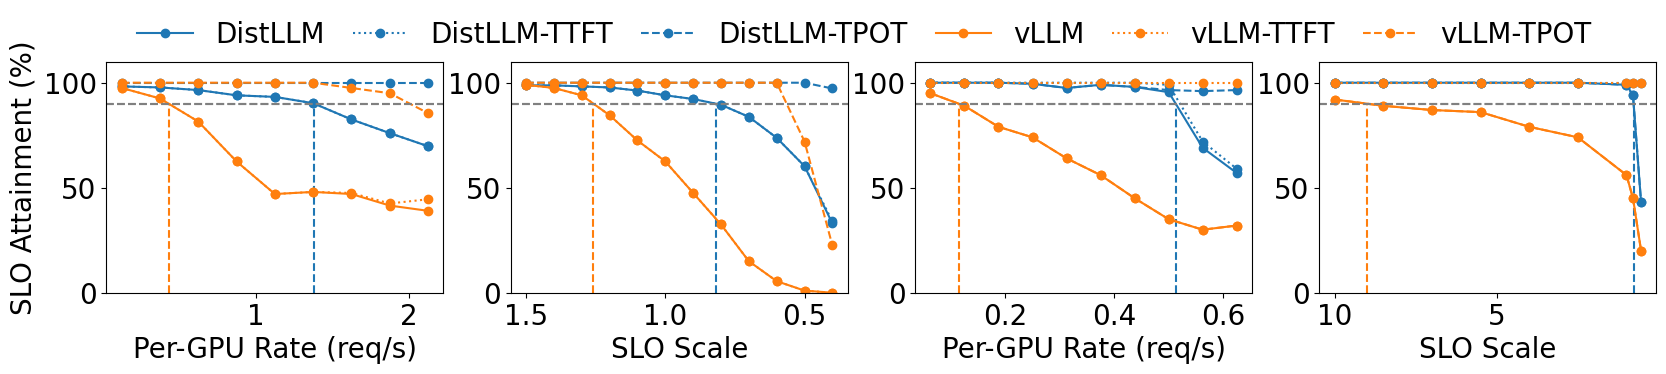

In [147]:
def plot_fig9():
    plt.rcParams.update({'font.size': 20})
    fig, axs = plt.subplots(1, 4, figsize=(20, 3))
    draw_attainment_rate_plot(
        axs[0],
        "opt-66b-humaneval",
        [(50, 0.125), (50, 0.375), (50, 0.625), (50, 0.875), (50, 1.125), (50, 1.375), (50, 1.625), (50, 1.875), (50, 2.125)],
        [
            Backend("fastserve-ctp4pp1-dtp2pp2", SYSNAME, "C0", 8),
            Backend("vllm-tp4", "vLLM", "C1", 4)
        ],
        0.125,
        0.2,
        90,
        show_ylabel=True
    )
    fig.legend(frameon=False, bbox_to_anchor = (0.88, 1.1, 0, 0), ncol=6,
    bbox_transform = plt.gcf().transFigure, columnspacing=1)
    draw_slo_scale_plot(
        axs[1],
        "opt-66b-humaneval",
        50, 0.875,
        [
            Backend("fastserve-ctp4pp1-dtp2pp2", SYSNAME, "C0", 8),
            Backend("vllm-tp4", "vLLM", "C1", 4)
        ],
        0.125,
        0.2,
        [1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4],
        90
    )
    draw_attainment_rate_plot(
        axs[2],
        "opt-66b-longbench",
        [(25, 0.0625), (25, 0.125), (25, 0.1875), (25, 0.25), (25, 0.3125), (25, 0.375), (25, 0.4375), (25, 0.5), (25, 0.5625), (25, 0.625)],
        [
            Backend("fastserve-ctp4pp1-dtp2pp2", SYSNAME, "C0", 8),
            Backend("vllm-tp4", "vLLM", "C1", 4)
        ],
        15,
        0.15,
        90,
    )
    draw_slo_scale_plot(
        axs[3],
        "opt-66b-longbench",
        25, 0.375,
        [
            Backend("fastserve-ctp4pp1-dtp2pp2", SYSNAME, "C0", 8),
            Backend("vllm-tp4", "vLLM", "C1", 4)
        ],
        15,
        0.15,
        [10.0, 8.5, 7.0, 5.5, 4.0, 2.5, 1.0, 0.8, 0.55],
        90
    )

plot_fig9()
plt.show()

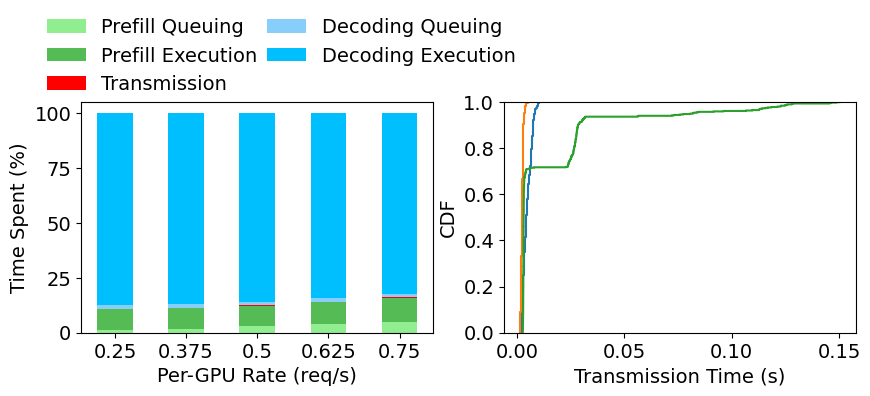

In [191]:
from distserve.lifetime import LifetimeEvent, LifetimeEventType, json_decode_lifetime_events
import numpy as np

stage_to_strs: list[str] = [
    "Prefill Queuing",
    "Prefill Execution",
    "Transmission",
    "Decoding Queuing",
    "Decoding Execution"
]
num_stages = len(stage_to_strs)
    
def analyse_one_request_result(result: RequestResult) -> np.array:
    """
    analyse_one_request_result: Analyse the time spend on a single request.
    """
    lifetime_event_dict = {}    # LifetimeEventType -> timestamp
    for event in result.lifecycle_events:
        lifetime_event_dict[event.event_type] = event.timestamp
    
    def get_event_timestamp_delta(event_type1: LifetimeEventType, event_type2: LifetimeEventType) -> float:
        return lifetime_event_dict[event_type2] - lifetime_event_dict[event_type1]
    
    result = np.array([
        get_event_timestamp_delta(LifetimeEventType.Issued, LifetimeEventType.ContextBegin),
        get_event_timestamp_delta(LifetimeEventType.ContextBegin, LifetimeEventType.ContextEnd),
        get_event_timestamp_delta(LifetimeEventType.MigrationBegin, LifetimeEventType.MigrationEnd),
        get_event_timestamp_delta(LifetimeEventType.ContextEnd, LifetimeEventType.MigrationBegin) + get_event_timestamp_delta(LifetimeEventType.MigrationEnd, LifetimeEventType.DecodingBegin),
        get_event_timestamp_delta(LifetimeEventType.DecodingBegin, LifetimeEventType.DecodingEnd)
    ])
    return result

def analyse_request_results(request_results: list[RequestResult]) -> np.array:
    """
    analyse_request_results: Analyse the time spend on all the requests and get an average of every stage's time spend fraction.
    """
    num_requests = len(request_results)
    total_time_spend_fracs = np.zeros(num_stages)
    for result in request_results:
        cur_result = analyse_one_request_result(result)
        cur_result /= cur_result.sum()
        cur_result *= 100
        total_time_spend_fracs += cur_result
    total_time_spend_fracs /= num_requests
    return total_time_spend_fracs

def plot_microbenchmark_bar(
    ax: plt.Axes,
    exp_result_dir: str,
    num_prompts_req_rates: list[(int, float)],
    backend: Backend
):
    colors = ["lightgreen", "#5b5", "red", "lightskyblue", "deepskyblue"]
    bar_width = 0.5
    plt.rcParams.update({'font.size': 14})
    bottoms = np.zeros(len(num_prompts_req_rates))
    for index in range(num_stages):
        stage_str = stage_to_strs[index]
        stage_time_fracs = []
        for num_prompts, req_rate in num_prompts_req_rates:
            results = load_result(exp_result_dir, backend, num_prompts, req_rate)
            time_frac = analyse_request_results(results)[index]
            stage_time_fracs.append(time_frac)
        ax.bar(
            [f"{req_rate}" for num_prompts, req_rate in num_prompts_req_rates],
            stage_time_fracs,
            bar_width,
            label=stage_str,
            bottom=bottoms,
            color=colors[index]
        )
        bottoms += stage_time_fracs

    ax.set_xlabel("Per-GPU Rate (req/s)")
    ax.set_ylabel("Latency Breakdown (%)")
    ax.legend(frameon=False, loc = (-0.12, 1.0), ncol=2,
          columnspacing=0.5)

def plot_migration_time_usage_cdf(
    ax: plt.Axes,
    label: str,
    exp_result_dir: str,
    num_prompts: int,
    request_rate: float,
    backend: Backend
):
    ax.set_ylabel("CDF")
    ax.set_xlabel("Transmission Time (s)")
    req_results = load_result(exp_result_dir, backend, num_prompts, request_rate)
    transmission_times = [
        analyse_one_request_result(result)[2]
        for result in req_results   
    ]
    transmission_times.sort()
    ax.ecdf(transmission_times, label=label)
    
def plot_fig10():
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    plot_microbenchmark_bar(
        axs[0],
        "opt-66b-sharegpt",
        [(25, 0.25), (25, 0.375), (25, 0.5), (25, 0.625), (25, 0.75)],
        Backend("fastserve-ctp4pp1-dtp2pp2", SYSNAME, "C0", 8)
    )
    plot_migration_time_usage_cdf(
        axs[1],
        "OPT-13B",
        "opt-13b-sharegpt",
        100, 2,
        Backend("fastserve-ctp2pp1-dtp1pp1", SYSNAME, "C0", 3)
    )
    plot_migration_time_usage_cdf(
        axs[1],
        "OPT-66B",
        "opt-66b-sharegpt",
        25, 0.375,
        Backend("fastserve-ctp4pp1-dtp2pp2", SYSNAME, "C0", 8)
    )
    plot_migration_time_usage_cdf(
        axs[1],
        "OPT-175B",
        "opt-175b-sharegpt",
        25, 0.1875,
        Backend("fastserve-ctp3pp3-dtp4pp3", SYSNAME, "C0", 21)
    )

plot_fig10()
plt.show()